# GCI Boostvqe Circuit Synthesis

Variational quantum eigensolver (VQE) is commonly used for ground state preparation. In this notebook, we demonstrate how to use a few steps of double-bracket quantum algorithms (DBQAs) to enhance the performance of VQE.

To achieve this, we use the `qibo` package to first train a warm-start VQE circuit, and from there, run a few steps of DBQAs realized by group commutator iterations (GCIs).

Then, the final circuit may be converted into `qiskit` or `pytekt` compatible formats for running on emulators or quantum hardwares.

In this example notebook, we perform numerical simulations of DBQA for the XXZ model with a periodic boundary condition, whose hamiltonian is given by:

$$
H = \sum _{k=0}^L \left( X_{k} X_{k + 1} + Y_{k} Y_{k + 1} + \delta Z_{k}Z_{k + 1} \right)
$$

In [8]:
import qibo
from qibo.backends import construct_backend
from qibo import hamiltonians
import matplotlib.pyplot as plt
import numpy as np

In [9]:
qibo.set_backend("tensorflow")
vqe_backend = construct_backend(backend="tensorflow")

[Qibo 0.2.12|INFO|2024-11-02 13:01:50]: Using tensorflow backend on /device:CPU:0


[Qibo 0.2.12|WARNING|2024-11-02 13:01:50]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


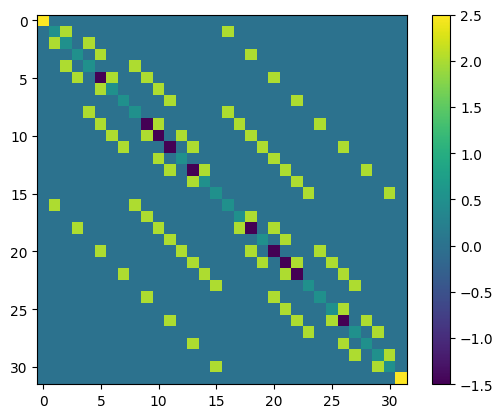

In [10]:
nqubits = 5
delta = 0.5
ham = hamiltonians.XXZ(nqubits, delta, dense=False)
plt.imshow(np.real(ham.matrix))
plt.colorbar()

## Step 1: train VQE

We define the lost function to be the energy expectation $\langle H\rangle$.

In [11]:
from boostvqe import ansatze
from copy import deepcopy
from functools import partial
from boostvqe.training_utils import vqe_loss
from boostvqe.utils import *

/Users/pethidine/Library/Caches/pypoetry/virtualenvs/boostvqe-9Q-2T4PW-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# helper functions
def exact_expectation_boost(ham, circ):
    # calculates the exact expectation of hamiltonian given a circuit in qibo
    return ham.expectation(
        ham.backend.execute_circuit(circuit=circ).state())

In [13]:
# build ansatz circuit
nlayer = 1
ansatz_circ = ansatze.hdw_efficient(nqubits, nlayer)
print(ansatz_circ.draw())

[Qibo 0.2.12|WARNING|2024-11-02 13:01:51]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RY─RZ─o───RY─RZ───o─RY─
q1: ─RY─RZ─Z───RY─RZ─o─|─RY─
q2: ─RY─RZ───o─RY─RZ─Z─|─RY─
q3: ─RY─RZ───Z─RY─RZ───|─RY─
q4: ─RY─RZ─────RY─RZ───Z─RY─


In [14]:
# build zero state
zero_state = ham.backend.zero_state(nqubits)
# initial params
params_len = len(ansatz_circ.get_parameters())
# fix numpy seed to ensure replicability of the experiment
seed = 10
np.random.seed(seed)
initial_params = np.random.uniform(-np.pi, np.pi, params_len)
print('Initial parameters:', initial_params)
# initial energy
c0 = deepcopy(ansatz_circ)
c0.set_parameters(initial_params)
target_energy = np.real(np.min(np.asarray(ham.eigenvalues())))
print('Target enegry:', target_energy)
print('Initial energy:', exact_expectation_boost(ham, c0).numpy())
print('Net difference:', exact_expectation_boost(ham, c0).numpy()-target_energy)

Initial parameters: [ 1.70475788 -3.01120431  0.83973663  1.5632809  -0.00938072 -1.72915367
 -1.89712697  1.63696274 -2.07903793 -2.58653723  1.16465009  2.84875441
 -3.11678496  0.07660625  1.96425543  0.70702213  1.39332975 -1.30768123
  2.62495223  1.34821941  0.26731415 -2.2483119  -0.79582348  1.09411377
 -0.36547294]
Target enegry: -6.280513769031045
Initial energy: 1.0802335771641438
Net difference: 7.360747346195189


In [15]:
# define the qibo loss function
objective_boost = partial(vqe_loss)
# logging hisotry
params_history, loss_history, grads_history, fluctuations = [], [], [], []
# set optimizer
optimizer = 'sgd'
maxiter = 1500
nmessage = 500
learning_rate = 5e-2
tol = 1e-5 # for `sgd` this is required but not used
params_history.append(initial_params)

In [16]:
# train vqe
# param = params_history[-1]
# (
#     partial_results,
#     partial_params_history,
#     partial_loss_history,
#     partial_grads_history,
#     partial_fluctuations,
#     vqe,
# ) = train_vqe(
#     deepcopy(ansatz_circ),
#     ham,  # Fixed hamiltonian
#     optimizer,
#     param,
#     tol=tol,
#     niterations=maxiter, # Show log info
#     nmessage=nmessage,
#     loss=objective_boost,
#     training_options={'nepochs': maxiter,
#                       'learning_rate': learning_rate,}
# )
# params_history.extend(np.array(partial_params_history))
# loss_history.extend(np.array(partial_loss_history))
# grads_history.extend(np.array(partial_grads_history))
# fluctuations.extend(np.array(partial_fluctuations))

In [17]:
# # plot the learning curve
# plt. plot(loss_history)

In [18]:
path_param = 'vqe_params_hist.npy'
# # np.save(path_param, params_history)

In [19]:
vqe_params = np.load(path_param)
vqe_param_final = vqe_params[-1]

We can compare the parameters:

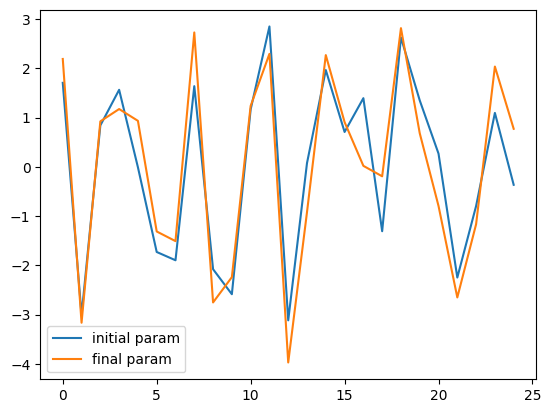

In [20]:
plt.plot(vqe_params[0], label='initial param')
plt.plot(vqe_params[-1], label='final param')
plt.legend()

The VQE circuit is then given by

In [21]:
ansatz_circ.set_parameters(vqe_param_final)
vqe_circ = ansatz_circ

## Step 2: GCI DBQA

A double-bracket rotation is given by
$$
H_{k+1} = e^{s_kW_k}H_ke^{-s_kW_k}
$$
where the rotation generator $W_k:=[D_k, H_k]$. 
Let us define the unitary operation $R_k = e^{-s_kW_k}$ ($W_k$ is anti-hermitian) and it can be approximated by group commutators:

$$
V^{(GC)}_k = e^{i\sqrt s_k H_k}e^{-i\sqrt s_k D_k}e^{-i\sqrt s_k H_k}e^{i\sqrt s_k D_k} = R_k + O(s_k^{3/2})
$$
or the higher-order product formulae (HOPF). 

$$
Q^{(HOPF)}_k = e^{i\phi\sqrt s_k H_k}e^{-i\phi\sqrt s_k D_k}e^{-i\phi\sqrt s_k H_k}e^{i(\phi+1)\sqrt s_k D_k}e^{i(1-\phi)\sqrt s_k H_k}e^{-i\sqrt s_k D_k} = R_k+O(s_k^2)
$$

Next, we shwo how to perform GCI DBQA based on the trained VQE circuit following these general steps:

1. Create a base oracle: compiles a circuit that performs $e^{-itH_0}$
2. Generate the frame-shifted evolution oracle: compose the VQE circuit with the base oracle to create $e^{-itH'}$ where $H'=V^\dagger H_0V$, $V$ being the VQE circuit trained earlier.
3. Initialize the GCI: determine the group commutator approximation and define the parameterization for $D_k$. 


In [22]:
base_oracle = XXZ_EvolutionOracle.from_nqubits(
    nqubits=nqubits, delta=0.5, steps=2, order=2
)
# the following circuit performs exp{-0.01iH}
base_circ = base_oracle.circuit(t_duration=0.01)
print(base_circ.draw())

[Qibo 0.2.12|WARNING|2024-11-02 13:01:51]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0:     ──────────────────────RZ─o─RY─X─RY─o────X───RZ─o──────X───RZ────────── ...
q1:     ────X───RZ─o──────X───RZ─|────|────|─RZ─o───RY─X───RY─o─────────X───RZ ...
q2:     ─RZ─o───RY─X───RY─o──────|────|────|──────X─RZ───o──────X─RZ─RZ─o───RY ...
q3:     ──────X─RZ───o──────X─RZ─|────|────|─RZ───o─RY───X─RY───o─────────X─RZ ...
q4:     ─RZ───o─RY───X─RY───o────X─RZ─o────X─RZ───────────────────RZ──────o─RY ...

q0: ... ────────────RZ─o─RY─X─RY─o─────────────────────────RZ─o─RY─X─RY─o────X ...
q1: ... ─o──────X───RZ─|────|────|───────X───RZ─o──────X───RZ─|────|────|─RZ─o ...
q2: ... ─X───RY─o──────|────|────|─RZ────o───RY─X───RY─o──────|────|────|───── ...
q3: ... ───o──────X─RZ─|────|────|─────────X─RZ───o──────X─RZ─|────|────|─RZ── ...
q4: ... ───X─RY───o────X─RZ─o────X─RZ─RZ───o─RY───X─RY───o────X─RZ─o────X─RZ── ...

q0: ... ───RZ─o──────X───RZ──────────────────────RZ─o─RY─X─RY─o────
q1: ... ───RY─X───RY─o─────────X───RZ─o──────X───RZ─|────|────|────
q2: ... ─X─RZ───o──────X─RZ─RZ─o

In [23]:
frame_oracle = FrameShiftedEvolutionOracle.from_evolution_oracle(
    circuit_frame=vqe_circ,
    base_evolution_oracle=base_oracle,
)

For group commutator, we can use the reduced third order group commutator:
$$
Q^{(3rd_red)}_k = e^{i\phi\sqrt s_k D_k}e^{-is_k H_k}e^{i(\phi+1)\sqrt s_k D_k}e^{i(1-\phi)\sqrt s_k H_k}e^{-is_k D_k}
$$
where $\phi = \frac{1}{2}(\sqrt 5 -1)$.

In [24]:
# db_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
db_rotation = DoubleBracketRotationType.group_commutator_reduced
gci = GroupCommutatorIterationWithEvolutionOracles(
        frame_oracle,
        db_rotation
    )

For our example, we choose $D$ to be parameterized by the Ising model:
$$
D = \sum_{j=1}^L(\alpha_j Z_j + \beta_j Z_{j+1}Z_{j})
$$

In [25]:
eo_d_type = IsingNNEvolutionOracle
print(
        f"The gci mode is {gci.mode} rotation with {eo_d_type.__name__} as the oracle.\n"
    )

The gci mode is DoubleBracketRotationType.group_commutator_reduced rotation with IsingNNEvolutionOracle as the oracle.



In [26]:
# GCI settings
steps = 1
optimization_method = "sgd"
gd_epochs = 10
opt_options = {'gd_epochs':gd_epochs, }

In [27]:
for gci_step_nmb in range(steps):
    logging.info(
        "\n################################################################################\n"
        + f"Optimizing GCI step {gci_step_nmb+1} with optimizer {optimization_method}"
        + "\n################################################################################\n"
    )
    it = time.time()
    if optimization_method == "sgd":
        params = (
            [4 - np.sin(x / 3) for x in range(nqubits)]
            if eo_d_type == MagneticFieldEvolutionOracle
            else [4 - np.sin(x / 3) for x in range(nqubits)] + nqubits * [1]
        )
        mode, best_s, best_b, eo_d = select_recursion_step_gd_circuit(
            gci,
            mode=db_rotation,
            eo_d_type=eo_d_type,
            params=params,
            step_grid=np.linspace(1e-5, 2e-2, 30),
            lr_range=(1e-3, 1),
            nmb_gd_epochs=gd_epochs,
            threshold=1e-4,
            max_eval_gd=30,
        )

        opt_dict = {"sgd_extras": "To be defined"}

    else:
        if gci_step_nmb == 0:
            p0 = [0.01]
            if eo_d_type == MagneticFieldEvolutionOracle:
                p0.extend([4 - np.sin(x / 3) for x in range(nqubits)])
            elif eo_d_type == IsingNNEvolutionOracle:
                p0.extend(
                    [4 - np.sin(x / 3) for x in range(nqubits)] + nqubits * [1]
                )

        else:
            p0 = [best_s]
            p0.extend(best_b)
        optimized_params, opt_dict = optimize_D(
            params=p0,
            gci=gci,
            eo_d_type=eo_d_type,
            mode=db_rotation,
            method=optimization_method,
            **opt_options,
        )
        best_s = optimized_params[0]
        best_b = optimized_params[1:]
        eo_d = eo_d_type.load(best_b)

    step_data = dict(
        best_s=best_s,
        eo_d_name=eo_d.__class__.__name__,
        eo_d_params=eo_d.params,
    )
    logging.info(f"Total optimization time required: {time.time() - it} seconds")
    gci.mode_double_bracket_rotation = db_rotation

    gci(best_s, eo_d, db_rotation)


INFO:root:
################################################################################
Optimizing GCI step 1 with optimizer sgd
################################################################################

INFO:root:Total optimization time required: 43.73758006095886 seconds


Just finished the selection: better loss -6.225392631067619 for mode DoubleBracketRotationType.group_commutator_reduced,                with duration s=0.02, and eo_d name = IsingNNEvolutionOracle


### Result analysis

In this analysis, we will look at the following attributes:

1. Fidelity
$$
F(\rho, \sigma) = \text{tr}^{2}\left( \sqrt{\sqrt{\sigma}
        \rho^{\dagger}\sqrt{\sigma}} \right)
$$
in our case, we are comparing the approximated ground state of our hamiltonian
and its analytical ground state.

Definition of fidelity
States

gate counts


In [33]:
from qibo.quantum_info.metrics import fidelity

In [44]:
energies = ham.eigenvalues()
ground_state_energy = float(energies[0])
ground_state = ham.ground_state()
ground_energy = float(ham.expectation(ground_state))
print(ground_state_energy)
print(ground_energy)

-6.280513769031045
-6.280513769031043


/Users/pethidine/Library/Caches/pypoetry/virtualenvs/boostvqe-9Q-2T4PW-py3.11/lib/python3.11/site-packages/tensorflow/python/framework/ops.py:307: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


In [34]:
def report(vqe_circ, hamiltonian, gci, step, eo_d, mode):
    energies = hamiltonian.eigenvalues()
    ground_state_energy = float(energies[0])
    vqe_energy = float(hamiltonian.expectation(vqe_circ().state()))
    gci_loss = float(gci.loss(step, eo_d, mode))
    gap = float(energies[1] - energies[0])

    return (
        dict(
            nqubits=hamiltonian.nqubits,
            gci_loss=float(gci_loss),
            vqe_energy=float(vqe_energy),
            target_energy=ground_state_energy,
            diff_vqe_target=vqe_energy - ground_state_energy,
            diff_gci_target=gci_loss - ground_state_energy,
            gap=gap,
            diff_vqe_target_perc=abs(vqe_energy - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc=abs(gci_loss - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            fidelity_witness_vqe=1 - (vqe_energy - ground_state_energy) / gap,
            fidelity_witness_gci=1 - (gci_loss - ground_state_energy) / gap,
            fidelity_vqe=fidelity(vqe_circ().state(), hamiltonian.ground_state()),
            fidelity_gci=fidelity(
                gci.get_composed_circuit(best_s, eo_d, db_rotation)().state(), hamiltonian.ground_state()
            ),
        )
        | gci.get_gate_count_dict()
    )
    
def print_report(report: dict):
    print(
        f"\
    The target energy is {report['target_energy']}\n\
    The VQE energy is {report['vqe_energy']} \n\
    The DBQA energy is {report['gci_loss']}. \n\
    The difference is for VQE is {report['diff_vqe_target']} \n\
    and for the DBQA {report['diff_gci_target']} \n\
    which can be compared to the spectral gap {report['gap']}.\n\
    The relative difference is \n\
        - for VQE {report['diff_vqe_target_perc']}% \n\
        - for DBQA {report['diff_gci_target_perc']}%.\n\
    The energetic fidelity witness of the ground state is: \n\
        - for the VQE  {report['fidelity_witness_vqe']} \n\
        - for DBQA {report['fidelity_witness_gci']}\n\
    The true fidelity is \n\
        - for the VQE  {report['fidelity_vqe']}\n\
        - for DBQA {report['fidelity_gci']}\n\
                    "
    )
    print(
        f"The boosting circuit used {report['nmb_cnot']} CNOT gates coming from compiled XXZ evolution and {report['nmb_cz']} CZ gates from VQE.\n\
For {report['nqubits']} qubits this gives n_CNOT/n_qubits = {report['nmb_cnot_relative']} and n_CZ/n_qubits = {report['nmb_cz_relative']}"
    )

In [35]:
this_report = report(vqe_circ, ham, gci, best_s, eo_d, db_rotation)
print_report(this_report)

    The target energy is -6.280513769031045
    The VQE energy is -5.66279054007824 
    The DBQA energy is -6.263577579083784. 
    The difference is for VQE is 0.617723228952805 
    and for the DBQA 0.01693618994726087 
    which can be compared to the spectral gap 4.440892098500626e-15.
    The relative difference is 
        - for VQE 9.835552498885884% 
        - for DBQA 0.2696624921160515%.
    The energetic fidelity witness of the ground state is: 
        - for the VQE  -139098905186496.6 
        - for DBQA -3813690936777.0
    The true fidelity is 
        - for the VQE  0.2204736343890342
        - for DBQA 0.24692889987658626
                    
The boosting circuit used 68 CNOT gates coming from compiled XXZ evolution and 12 CZ gates from VQE.
For 5 qubits this gives n_CNOT/n_qubits = 2.4 and n_CZ/n_qubits = 13.6


We see that based on the numerical simulation, a simple step of GCI DBQA further lowered the loss. From here, we can export the VQE+DBQA circuit in QASM format

In [36]:
gci_circ = gci.get_composed_circuit()
composed_circ = gci._forward(best_s, eo_d, db_rotation) + gci_circ

In [40]:
print("Circuit depth:", composed_circ.depth)
num_cnots = sum(1 for gate in composed_circ.queue if isinstance(gate, gates.CNOT))
print("CNOT counts:", num_cnots)

Circuit depth: 383
CNOT counts: 272


In [ ]:
vqe_c = models.Circuit.to_qasm(vqe_circ)
gci_c = models.Circuit.to_qasm(composed_circ)

In [ ]:
with open("vqe_circ.qasm", "w") as file:
    file.write(vqe_c)

with open("gci_circ.qasm", "w") as file:
    file.write(gci_c)